In [26]:
# 1. Imports & Paths
import importlib.util
import os, sys, re, pandas as pd
sys.path.append(os.path.join(os.pardir, "utils"))

DATA_DIR = os.path.join(os.pardir, "data")
resume_path = os.path.join(DATA_DIR, "resumes_cleaned.csv")
jobs_path   = os.path.join(DATA_DIR, "jobs_cleaned.csv")


EMB_DIR = os.path.join(os.pardir, "data/embeddings")
remb_path = os.path.join(EMB_DIR, "resume_embeddings.npy")
jemb_path   = os.path.join(EMB_DIR, "job_embeddings.npy")

In [27]:
%load_ext autoreload
%autoreload 2
from utils import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
resume_df = pd.read_csv(resume_path)
job_posts_df = pd.read_csv(jobs_path)
resume_embeddings = np.load(remb_path)
job_embeddings = np.load(jemb_path)

In [29]:
def domain_score_vector(text, domain_keywords=DOMAIN_KEYWORDS_REFERENCE):
    text_lower = str(text).lower()
    return {
        domain: sum(kw in text_lower for kw in keywords)
        for domain, keywords in domain_keywords.items()
    }

def detect_domain(text, domain_keywords=DOMAIN_KEYWORDS_REFERENCE):
    scores = domain_score_vector(text, domain_keywords)
    return max(scores, key=scores.get) if max(scores.values()) > 0 else "other"

In [30]:
scaler = MinMaxScaler()

In [31]:
resume_domain_vectors = [domain_score_vector(t) for t in resume_df["Resume_clean"]]
resume_domain_df = pd.DataFrame(resume_domain_vectors, index=resume_df.index)

resume_scaler = MinMaxScaler()
resume_domain_scaled = resume_scaler.fit_transform(resume_domain_df)

resume_features = np.hstack([resume_embeddings, resume_domain_scaled])

kmeans = KMeans(n_clusters=6, random_state=42)
resume_labels = kmeans.fit_predict(resume_features)
resume_df["cluster"] = resume_labels


In [32]:
resume_cluster_summary = (
    resume_df.drop(columns=["ID"], errors="ignore") 
            .join(resume_domain_df)
             .groupby("cluster")
             .mean(numeric_only=True)
)

print(resume_cluster_summary)

domain_cols =  ["Tech & IT", "Finance & Accounting", "Business & Sales", "Law & Advocacy", "Healthcare", "HR & Operations", "Creative & Design","Education",
 "Manufacturing & Construction", "Agriculture & Environment","Hospitality & Food", "Other Services"]
# domain_cols = ["hr", "finance", "it", "sales", "administration", "research"]

top_domain = resume_cluster_summary[domain_cols].idxmax(axis=1)
for c, dom in top_domain.items():
    print(f"Resume Cluster {c}: primarily {dom.upper()}")

         Tech & IT  Finance & Accounting  Business & Sales  Law & Advocacy  \
cluster                                                                      
0         2.035343              0.613306          0.212058        0.139293   
1         0.762963              0.736296          0.802963        0.232593   
2         0.400990              0.539604          0.054455        0.183168   
3         0.917040              4.594170          0.311659        0.511211   
4         0.844221              1.140704          0.447236        0.414573   
5         0.762411              0.890071          0.294326        0.578014   

         Healthcare  HR & Operations  Creative & Design  Education  \
cluster                                                              
0          0.357588         1.093555           0.345114   1.083160   
1          0.524444         0.837037           0.742222   1.057778   
2          0.782178         0.811881           0.212871   2.801980   
3          0.522422      

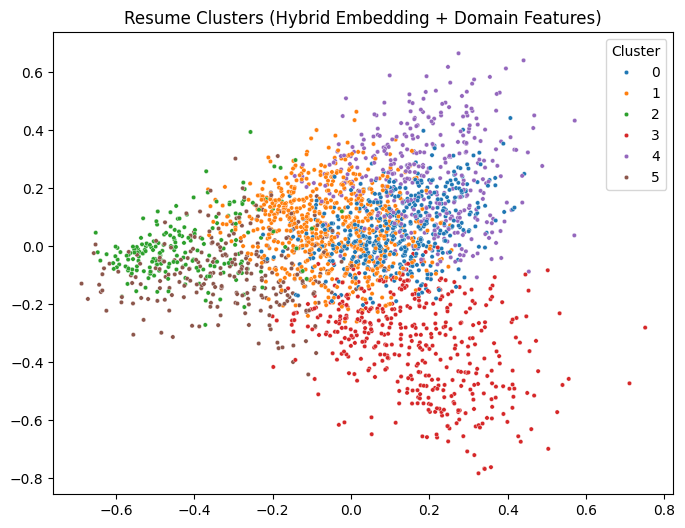

cluster                         0    1    2    3    4    5
domain_label                                              
Agriculture & Environment       6    3    0    0    0    0
Business & Sales                1   91    1    0   10    1
Creative & Design               6   85    4    0   12    0
Education                      11   33  130    0    2    0
Finance & Accounting           18  101    6  301   54    5
HR & Operations                36   71   20  126   82   16
Healthcare                     10   39   30    2   22  248
Hospitality & Food              1  111    3    1   15    0
Law & Advocacy                  3   16    2    6    9    7
Manufacturing & Construction  235    7    0    0   15    2
Other Services                  3    1    1    0  141    0
Tech & IT                     151  116    5   10   36    3
other                           0    1    0    0    0    0


In [33]:
# --- 10. Visualize clusters (PCA 2D) ---
pca = PCA(n_components=2, random_state=42)
reduced = pca.fit_transform(resume_features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=reduced[:,0], y=reduced[:,1], hue=resume_labels, palette="tab10", s=10)
plt.title("Resume Clusters (Hybrid Embedding + Domain Features)")
plt.legend(title="Cluster")
plt.show()

# --- 11. Inspect domain distribution per cluster ---
domain_labels = [detect_domain(t) for t in resume_df["Resume_clean"]]
resume_df["domain_label"] = domain_labels
domain_cluster_ct = pd.crosstab(resume_df["domain_label"], resume_df["cluster"])
print(domain_cluster_ct)

In [34]:
job_domain_vectors = [domain_score_vector(t) for t in job_posts_df["job_text_clean"]]
job_domain_df = pd.DataFrame(job_domain_vectors, index=job_posts_df.index)

# --- 13. Scale domain features (separate scaler) ---
job_scaler = MinMaxScaler()
job_domain_scaled = job_scaler.fit_transform(job_domain_df)

# --- 14. Combine embeddings + domain features ---
job_features = np.hstack([job_embeddings, job_domain_scaled])

In [35]:
# --- Compute domain features ---
job_domain_vectors = [domain_score_vector(t) for t in job_posts_df["job_text_clean"]]
job_domain_df = pd.DataFrame(job_domain_vectors)

# --- Normalize domain scores ---
scaler = MinMaxScaler()
job_domain_scaled = scaler.fit_transform(job_domain_df)

# --- Combine embeddings + domain features ---
job_features = np.hstack([job_embeddings, job_domain_scaled])

# --- Cluster ---
kmeans_jobs = KMeans(n_clusters=6, random_state=42)
job_labels = kmeans_jobs.fit_predict(job_features)
job_posts_df["cluster"] = job_labels

# --- Summarize by domain ---
domain_cols = [
    "Tech & IT",
    "Finance & Accounting",
    "Business & Sales",
    "Law & Advocacy",
    "Healthcare",
    "HR & Operations",
    "Creative & Design",
    "Education",
    "Manufacturing & Construction",
    "Agriculture & Environment",
    "Hospitality & Food",
    "Other Services"
]
job_cluster_summary = (
    pd.concat([job_posts_df["cluster"], job_domain_df], axis=1)
      .groupby("cluster")[domain_cols]
      .mean()
)
print(job_cluster_summary.round(2))

# --- Identify top domain per job cluster ---
domain_cols = [
    "Tech & IT",
    "Finance & Accounting",
    "Business & Sales",
    "Law & Advocacy",
    "Healthcare",
    "HR & Operations",
    "Creative & Design",
    "Education",
    "Manufacturing & Construction",
    "Agriculture & Environment",
    "Hospitality & Food",
    "Other Services"
]

top_domain = job_cluster_summary[domain_cols].idxmax(axis=1)
for c, dom in top_domain.items():
    print(f"Job Cluster {c}: primarily {dom.upper()}")


         Tech & IT  Finance & Accounting  Business & Sales  Law & Advocacy  \
cluster                                                                      
0             1.88                  0.06              0.02            0.00   
1             0.15                  0.26              0.19            0.14   
2             0.43                  0.70              0.17            0.23   
3             4.51                  0.05              0.03            0.00   
4             0.25                  3.19              0.17            0.18   
5             0.48                  0.27              0.21            0.07   

         Healthcare  HR & Operations  Creative & Design  Education  \
cluster                                                              
0              0.01             0.28               0.38       0.13   
1              0.22             0.30               0.10       0.46   
2              0.24             0.77               0.11       0.39   
3              0.01      

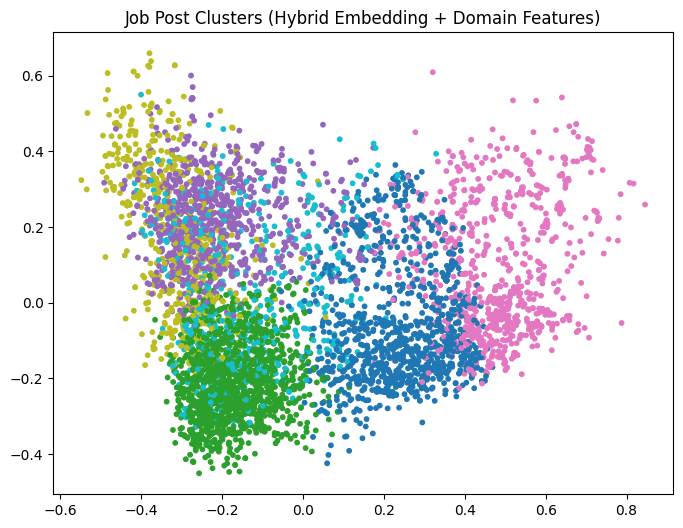

In [36]:
pca = PCA(n_components=2, random_state=42)
job_reduced = pca.fit_transform(job_features)

plt.figure(figsize=(8,6))
plt.scatter(job_reduced[:,0], job_reduced[:,1],
            c=job_labels, cmap='tab10', s=10)
plt.title("Job Post Clusters (Hybrid Embedding + Domain Features)")
plt.show()


In [37]:
resume_df.to_csv("resumes_with_cluster5.csv", index=False)
job_posts_df.to_csv("jobs_with_cluster5.csv", index=False)
